# Imports necesarios para nuestra Red

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM



# Dataset del consumo de Energía

Dado que el dataset que se encuentra en la página de la CENACE es un archivo winrar, y dentro de este archivo están los pronósticos de demanda DIARIOS; quiere decir, hay un archivo csv por día, tuvimos que crear una función que concatenara todos los archivos, además, crear una columna que indicara el día en el que fue creado el dataset para que cada registro correspondiera al día en cuestión

In [2]:
def combine_csv_files(carpet_path, output_filename):
    # Obtener la lista de archivos CSV en el directorio especificado
    csv_files = [os.path.join(carpet_path, file) for file in os.listdir(carpet_path) if file.endswith(".csv")]

    # Columnas a excluir durante la concatenación
    exclude_columns = ['SISTEMA', 'AREA', 'ZONA', 'HORA', 'PRONOSTICO_MWH']

    month_mapping = {
        'ene': 'Jan',
        'feb': 'Feb',
        'mar': 'Mar',
        'abr': 'Apr',
        'may': 'May',
        'jun': 'Jun',
        'jul': 'Jul',
        'ago': 'Aug',
        'sep': 'Sep',
        'oct': 'Oct',
        'nov': 'Nov',
        'dic': 'Dec'
    }
    
    # Cargar los archivos CSV en DataFrames
    dfs = []
    for file in csv_files:
        with open(file, 'r') as f:
            # Leer la fila 5 y extraer la fecha
            lines = f.readlines()
            match = re.search(r'\d{2}/\w+/\d{4}', lines[10])
            date = match.group(0) if match else None

        # Cargar el archivo CSV en un DataFrame
        df = pd.read_csv(file, skiprows=7)

        # Agregar la columna 'Date' con la fecha extraída
        df['Date'] = date
        for month_es, month_en in month_mapping.items():
            df['Date'] = df['Date'].str.replace(month_es, month_en)
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%b/%Y').dt.strftime('%Y-%m-%d')

        # Excluir las columnas no deseadas si existen en el DataFrame
        columns_to_drop = [col for col in exclude_columns if col in df.columns]
        if columns_to_drop:
            df = df.drop(columns=columns_to_drop)
        dfs.append(df)

    # Concatenar los DataFrames en uno solo
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])

    # Exportar el DataFrame a un archivo CSV con el nombre especificado
    combined_df.to_csv(output_filename, index=False)


In [412]:
# Carpeta CENACE debe contener los archivos CSV extraídos del archivo rar de CENACE
carpet_path = r"C:\Users\Panda\Documents\GitHub\energyPrediction\cenace"
nombre = "combined_df.csv"
combine_csv_files(carpet_path, nombre)

# Este código sólo se corrió una vez ya que la concatenación de todos los archivos CSV toma mucho tiempo y no es necesario volver a hacerlo

In [3]:
# Leer el archivo CSV combinado
combined_df = pd.read_csv('combined_df.csv')
combined_df.describe(include='all')

,Sistema,Area,Zona de Carga,Hora,Pronostico (MWh),Date
count,4088420,4088420,4088420,4.088420e+06,4.088420e+06,4080644
unique,3,9,109,NaN,NaN,1559
top,SIN,ORI,SALTILLO,NaN,NaN,2019-07-22
freq,3824256,1179648,37896,NaN,NaN,20928
mean,NaN,NaN,NaN,1.250009e+01,3.373365e+02,NaN
std,NaN,NaN,NaN,6.922365e+00,4.199072e+02,NaN
min,NaN,NaN,NaN,1.000000e+00,0.000000e+00,NaN
25%,NaN,NaN,NaN,6.000000e+00,1.008460e+02,NaN
50%,NaN,NaN,NaN,1.200000e+01,1.983450e+02,NaN
75%,NaN,NaN,NaN,1.800000e+01,4.294823e+02,NaN


In [4]:
# promedio de energia diaria consumida por zona de carga
energy = combined_df.groupby(['Date', ' Zona de Carga'], as_index=False)[' Pronostico (MWh)'].sum()
energy['Date'] = pd.to_datetime(energy['Date'])

energy = energy.reset_index(drop=True)
energy.head()

,Date,Zona de Carga,Pronostico (MWh)
0,2019-01-09,ACAPULCO,5922.070
1,2019-01-09,AGUASCALIENTES,12573.985
2,2019-01-09,APATZINGAN,2406.721
3,2019-01-09,CABORCA,2360.058
4,2019-01-09,CAMARGO,7699.491


In [5]:
print("Día de inicio de los datos",min(energy.Date))
print("Día final de los datos",max(energy.Date))

Día de inicio de los datos 2019-01-09 00:00:00
Día final de los datos 2023-06-02 00:00:00


# Datos Climatológicos

Este dataset tuvimos que buscarlo por otro lado ya que los archivos, o datos abiertos, que otorga la CENACE, no incluye información al respecto sobre el clima en ese día

In [101]:

clima_df = pd.read_csv('clima.csv', skiprows=18)

# Convertir las columnas 'YEAR', 'MO' y 'DY' en una columna de fecha con el formato '%Y-%m-%d'
clima_df['Date'] = pd.to_datetime(clima_df[['YEAR', 'MO', 'DY']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')

#Eliminar las primeras 3 columnas
clima_df = clima_df.drop(columns=['YEAR', 'MO', 'DY'])

clima_df.tail()


,ALLSKY_SFC_UV_INDEX,WS2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,QV2M,RH2M,PS,Date
1600,-999.0,2.84,27.12,10.44,18.79,36.21,18.44,8.24,42.19,99.27,2023-05-29
1601,-999.0,3.29,26.72,9.94,18.33,34.65,18.75,8.00,39.56,99.14,2023-05-30
1602,-999.0,3.12,25.01,7.00,16.01,32.50,17.32,6.53,36.00,99.00,2023-05-31
1603,-999.0,2.94,24.01,8.31,16.16,31.58,17.21,6.96,40.06,99.13,2023-06-01
1604,-999.0,2.06,25.52,8.90,17.21,34.15,17.62,7.26,39.38,99.14,2023-06-02


**Significado de los parámetros con sus respectivas unidades**

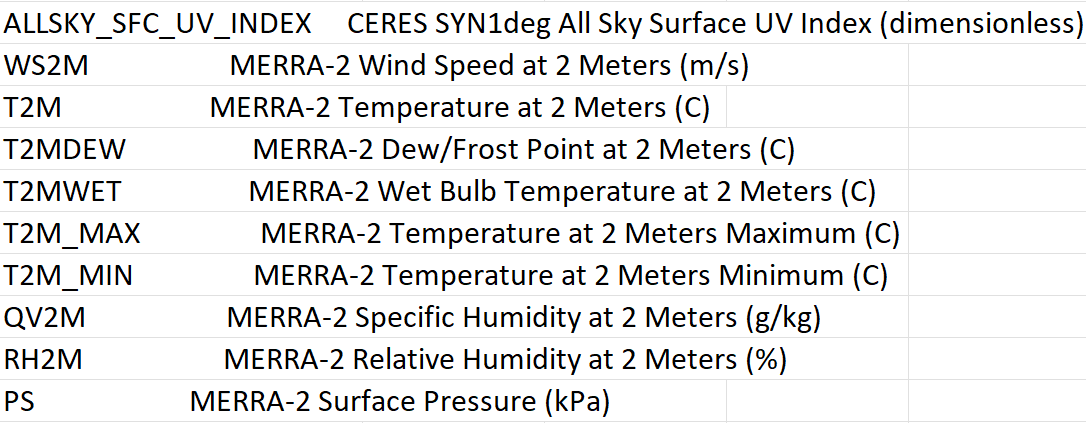

# DataFrame Energía-Clima

En esta sección hacemos una copia del dataframe de energía diaria por ciudad con la intención de hacer un nuevo dataframe con datos de la ciudad de *Hermosillo*

In [102]:
energy_city = energy.loc[energy[' Zona de Carga'] == 'HERMOSILLO'].copy()
energy_city['Date'] = pd.to_datetime(energy_city['Date'])

# Eliminar filas con valores que aparentemente son outliers
fechas_outliers = ['2019-06-07', '	2019-07-22', '2019-08-22','2020-08-24']
energy_city = energy_city.drop(energy_city[energy_city['Date'].isin(fechas_outliers)].index)

energy_city = energy_city.reset_index(drop=True)
energy_city.tail()


,Date,Zona de Carga,Pronostico (MWh)
1550,2023-05-29,HERMOSILLO,18152.372
1551,2023-05-30,HERMOSILLO,18065.694
1552,2023-05-31,HERMOSILLO,17591.781
1553,2023-06-01,HERMOSILLO,17086.090
1554,2023-06-02,HERMOSILLO,16674.799


## **NOTA!**
 La gráfica de abajo nos indicaba que habían unos datos "extraños". Debido a que no tenemos conocimientos sobre cómo tratar con este tipo de datos (outliers), decidimos encontrar las fechas donde el consumo era exagerado, para luego eliminarlos.\
    Sabemos que hacer esto no está del todo bien, sin embargo, para fines prácticos esta será la metodología que seguiremos.

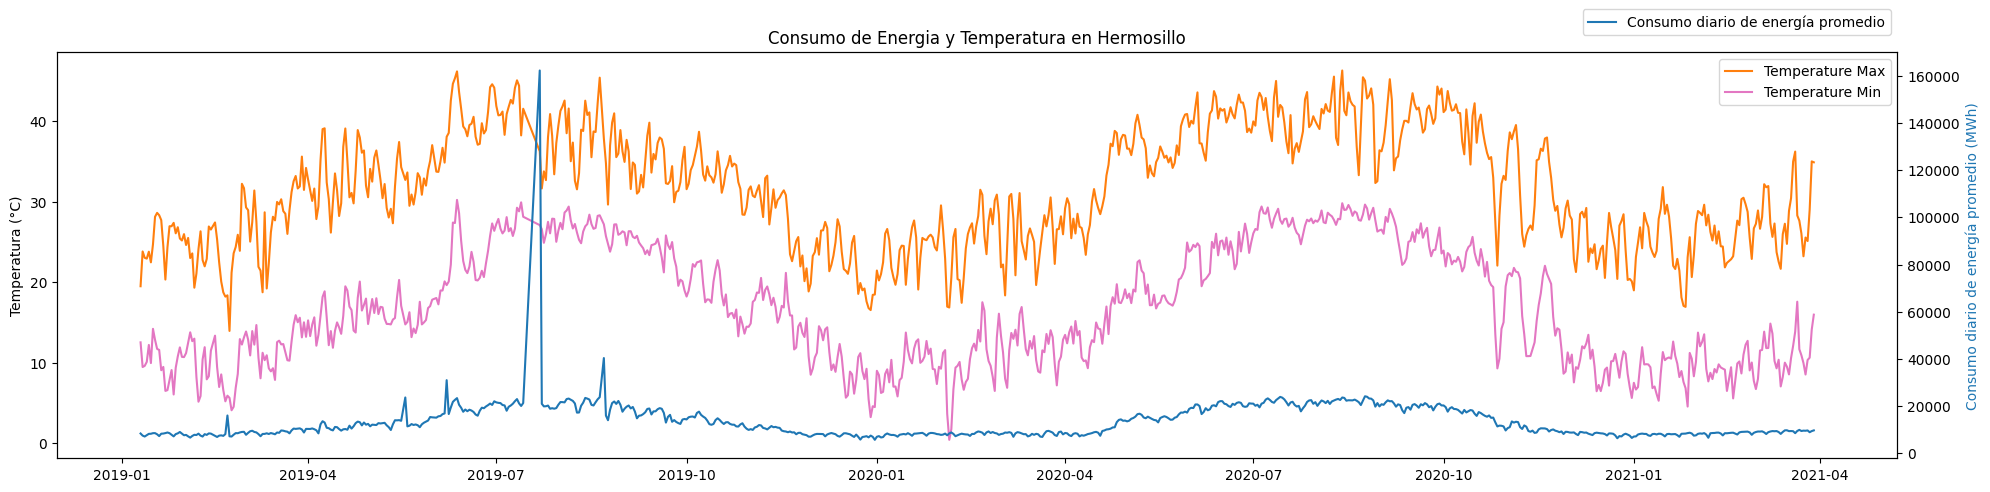

In [103]:
clima_df = clima_df.drop(clima_df[clima_df['Date'].isin(fechas_outliers)].index)

In [104]:
# Merge del clima con la energía
clima_energia = energy_city.merge(clima_df, on='Date', how='inner')
clima_energia = clima_energia.reset_index(drop=True)
clima_energia.describe()

,Pronostico (MWh),ALLSKY_SFC_UV_INDEX,WS2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,QV2M,RH2M,PS
count,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000
mean,13442.890088,-134.065450,2.315090,23.578945,8.140708,15.859903,31.751178,16.887169,7.994704,44.179048,99.352555
std,5202.047917,342.947187,0.671852,6.678613,8.555881,6.820393,6.608578,6.751705,4.647860,16.689438,0.300598
min,5720.669000,-999.000000,0.770000,7.690000,-15.490000,0.710000,13.960000,0.440000,1.040000,6.810000,98.520000
25%,8806.588500,0.810000,1.800000,17.542500,2.260000,10.605000,26.457500,11.120000,4.640000,32.500000,99.130000
50%,11856.618000,1.620000,2.270000,23.520000,6.860000,14.655000,32.220000,16.050000,6.410000,43.120000,99.330000
75%,18380.096000,2.480000,2.747500,29.415000,14.685000,21.857500,36.897500,23.370000,10.830000,56.690000,99.570000
max,25699.446000,3.220000,4.990000,38.140000,24.480000,28.280000,46.300000,30.230000,19.470000,91.690000,100.300000


In [105]:
clima_energia.loc[clima_energia[' Pronostico (MWh)'] == max(clima_energia[' Pronostico (MWh)'])]

,Date,Zona de Carga,Pronostico (MWh),ALLSKY_SFC_UV_INDEX,WS2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,QV2M,RH2M,PS
1241,2022-06-23,HERMOSILLO,25699.446,2.64,3.05,34.94,18.34,26.64,42.1,28.94,13.55,40.81,98.87


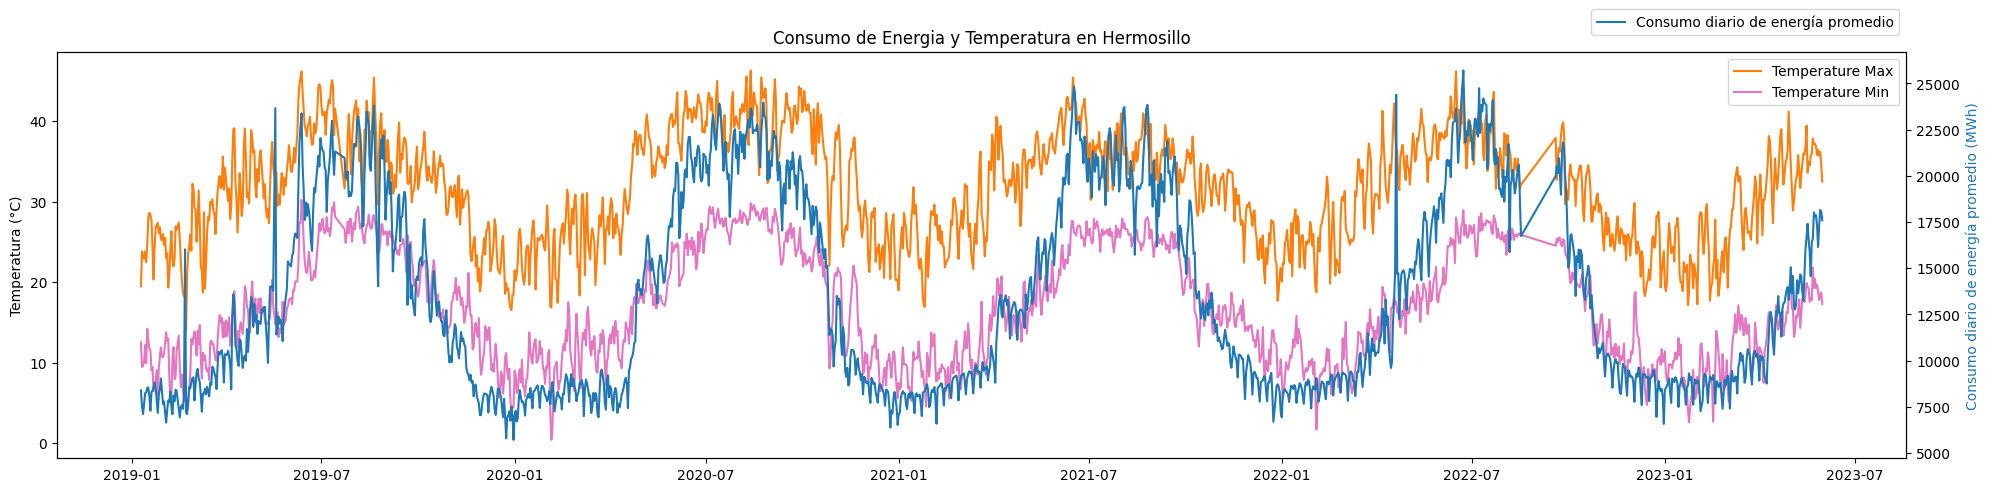

In [106]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(clima_energia['Date'][:-2], clima_energia['T2M_MAX'][:-2], color='tab:orange', label='Temperature Max')
ax1.plot(clima_energia['Date'][:-2], clima_energia['T2M_MIN'][:-2], color='tab:pink', label='Temperature Min')
ax1.set_ylabel('Temperatura (°C)')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(clima_energia['Date'][:-2], clima_energia[' Pronostico (MWh)'][:-2], color='tab:blue', label='Consumo diario de energía promedio')
ax2.set_ylabel('Consumo diario de energía promedio (MWh)', color='tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))

plt.title('Consumo de Energia y Temperatura en Hermosillo')
fig.tight_layout()
plt.show()

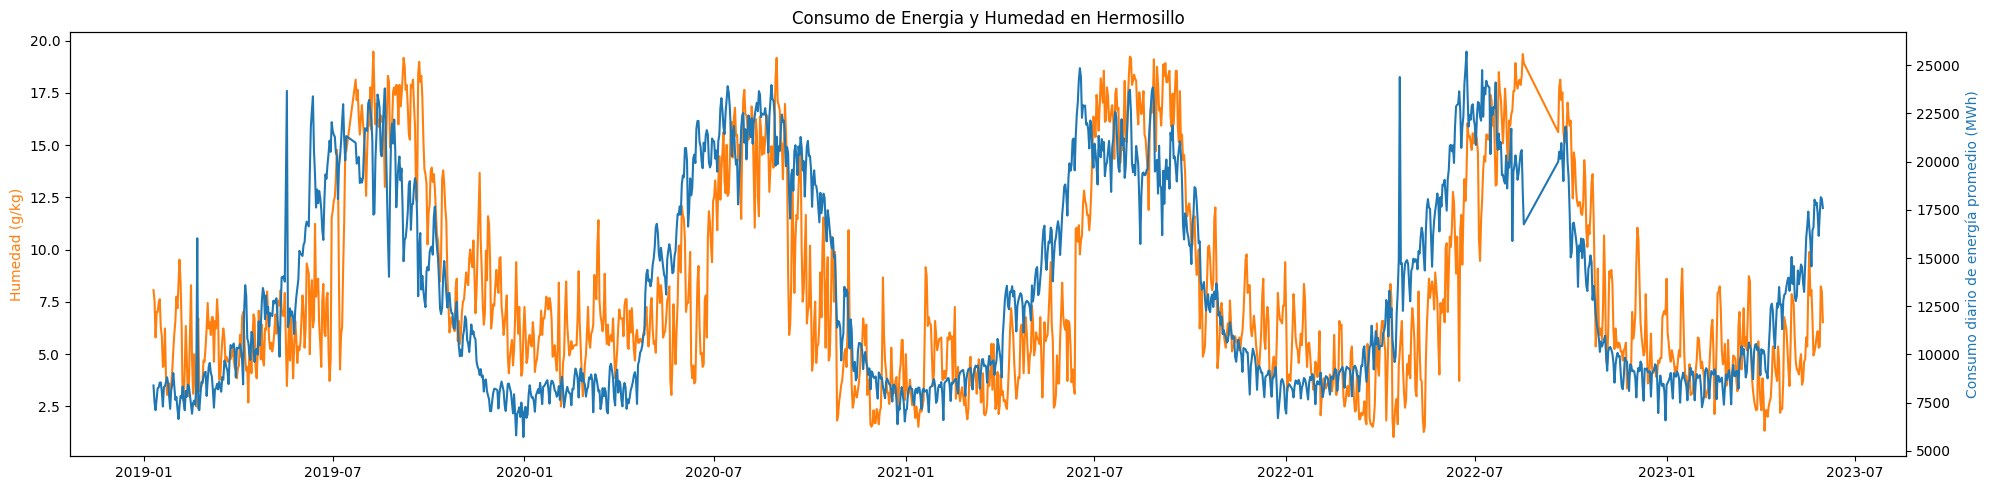

In [107]:

fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(clima_energia['Date'][:-2], clima_energia['QV2M'][:-2], color='tab:orange', label='Humedad')
ax1.set_ylabel('Humedad (g/kg)', color='tab:orange')

ax2 = ax1.twinx()
ax2.plot(clima_energia['Date'][:-2], clima_energia[' Pronostico (MWh)'][:-2], color='tab:blue', label='Consumo diario de energía promedio')
ax2.set_ylabel('Consumo diario de energía promedio (MWh)', color='tab:blue')

plt.title('Consumo de Energia y Humedad en Hermosillo')
fig.tight_layout()
plt.show()

In [108]:
corr = clima_energia.corr(numeric_only=True)
corr

,Pronostico (MWh),ALLSKY_SFC_UV_INDEX,WS2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,QV2M,RH2M,PS
Pronostico (MWh),1.000000,0.195800,0.113658,0.921075,0.675844,0.874900,0.833953,0.921710,0.717039,0.041573,-0.684490
ALLSKY_SFC_UV_INDEX,0.195800,1.000000,-0.071812,0.221511,0.243203,0.260984,0.185888,0.253227,0.246760,0.105094,-0.169039
WS2M,0.113658,-0.071812,1.000000,0.102677,-0.179447,-0.062298,0.157786,0.017832,-0.163490,-0.293021,-0.172308
T2M,0.921075,0.221511,0.102677,1.000000,0.597195,0.864222,0.956048,0.962800,0.628373,-0.115653,-0.736494
T2MDEW,0.675844,0.243203,-0.179447,0.597195,1.000000,0.919651,0.387625,0.743849,0.969614,0.706793,-0.429732
T2MWET,0.874900,0.260984,-0.062298,0.864222,0.919651,1.000000,0.711249,0.937996,0.915859,0.386710,-0.630164
T2M_MAX,0.833953,0.185888,0.157786,0.956048,0.387625,0.711249,1.000000,0.853148,0.422021,-0.343157,-0.700427
T2M_MIN,0.921710,0.253227,0.017832,0.962800,0.743849,0.937996,0.853148,1.000000,0.773288,0.094210,-0.691712
QV2M,0.717039,0.246760,-0.163490,0.628373,0.969614,0.915859,0.422021,0.773288,1.000000,0.657080,-0.434564
RH2M,0.041573,0.105094,-0.293021,-0.115653,0.706793,0.386710,-0.343157,0.094210,0.657080,1.000000,0.071192


Hacemos esta correlacion con la intención de ver la relación entre las variables de nuestro dataframe y poder decidir en un futuro qué variables nos pueden interesar más que otras

# Clusters del Clima

Los clusters sirven para la agrupación de datos, en este caso datos climáticos. Estos grupos se forman basados en características propias de los datos y lo hacemos con la intención de encontrar su impacto o patrones que nos puedan servir en la predicción de energía

In [109]:
scaler = MinMaxScaler(feature_range=(0, 1))
clima_escalado = scaler.fit_transform(clima_energia[['T2M_MAX', 'RH2M','WS2M']])

K-means es un algoritmo de aprendizaje automático no supervisado y nos ayuda a agrupar los datos, haciendo que sean similares entre sí y diferente entre los demás

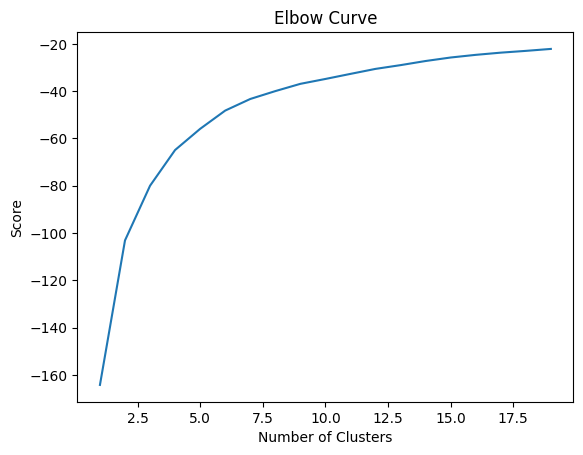

In [110]:
# k optima  
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i, n_init=10) for i in Nc]
kmeans

score = [kmeans[i].fit(clima_escalado).score(clima_escalado) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [111]:
kmeans = KMeans(n_clusters=5, n_init=10,max_iter=600, algorithm = 'lloyd')
kmeans.fit(clima_escalado)
clima_energia['clima_cluster'] = kmeans.labels_

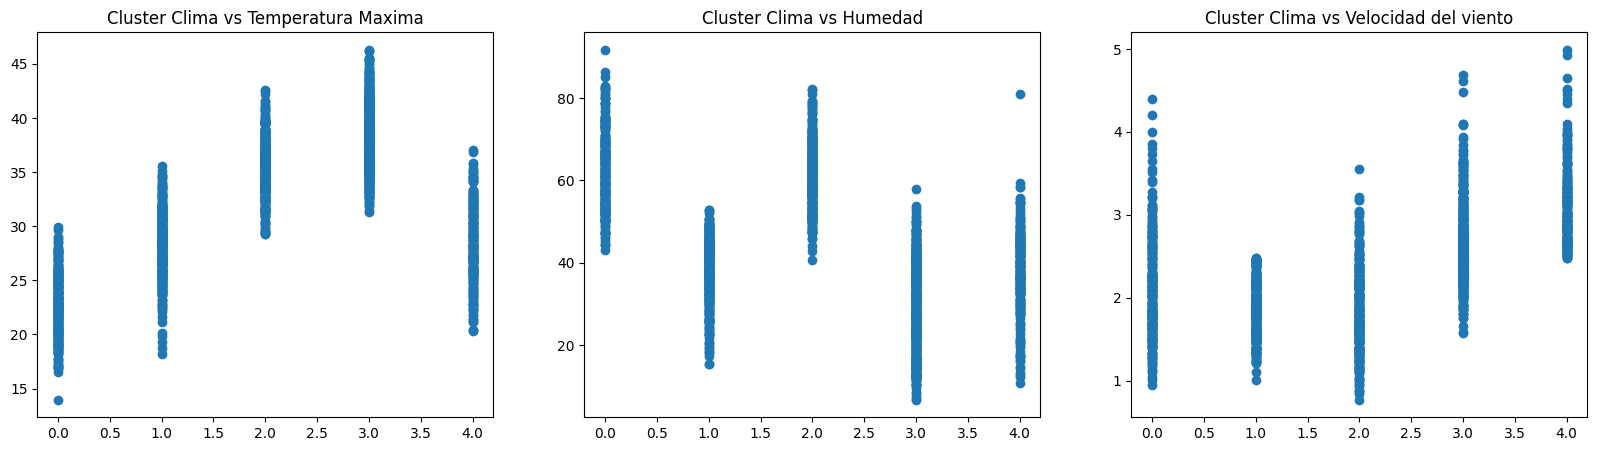

In [112]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(clima_energia.clima_cluster[:-2], clima_energia.T2M_MAX[:-2])
plt.title('Cluster Clima vs Temperatura Maxima')

plt.subplot(1, 3, 2)
plt.scatter(clima_energia.clima_cluster[:-2], clima_energia.RH2M[:-2])
plt.title('Cluster Clima vs Humedad')

plt.subplot(1, 3, 3)
plt.scatter(clima_energia.clima_cluster[:-2], clima_energia.WS2M[:-2])
plt.title('Cluster Clima vs Velocidad del viento')

plt.show()

Esto nos permite visualizar la relación entre los clusters de clima

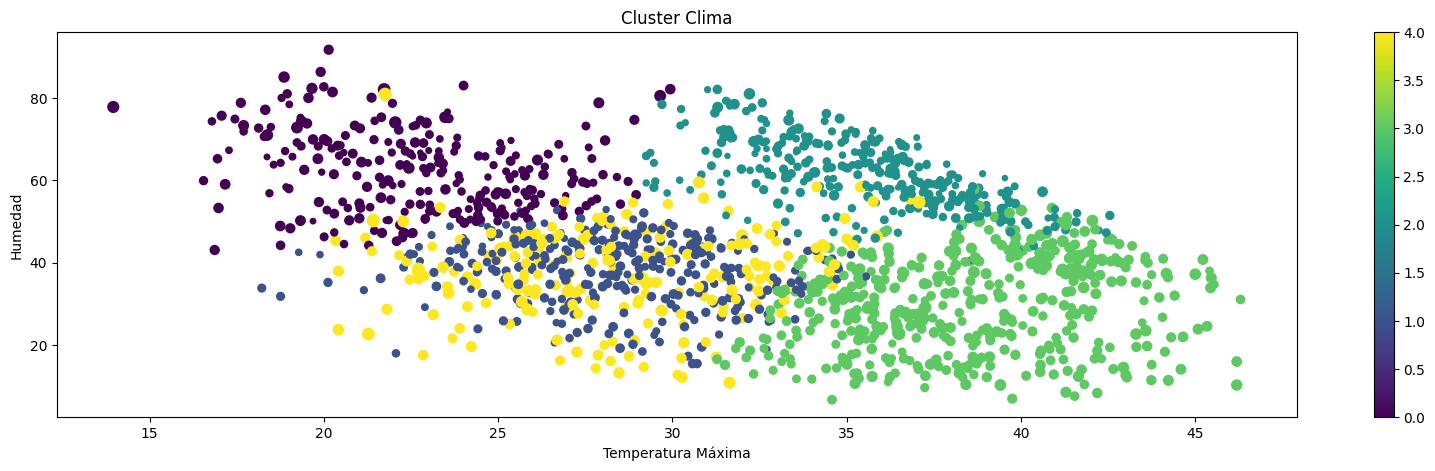

In [113]:
fig, ax1 = plt.subplots(figsize=(20, 5))
scatter = ax1.scatter(clima_energia.T2M_MAX[:-2], 
                      clima_energia.RH2M[:-2],
                      s=clima_energia.WS2M[:-2]*15,
                      c=clima_energia.clima_cluster[:-2])
ax1.set_xlabel('Temperatura Máxima')
ax1.set_ylabel('Humedad')

plt.colorbar(scatter)  # Agregar la barra de colores
plt.title('Cluster Clima')
plt.show()


Nos permite ver la relación de las variables del clima y la asignación del color indica el cluster asignado. Podemos notar lo siguiente: \
- La temperatura, mientras más va aumentando, la humedad (relativa) [^1] disminuye
- Aunque no se alcanza a ver, el tamaño de los puntos indica la influencia de la velocidad del viento entre estas variables de clima, y al parecer no tiene gran relevancia

[^1]: La humedad relativa indica el % de agua (humedad) que hay en el aire

# Indicador de dias festivos


In [114]:
os.chdir(r'C:\Users\Panda\Documents\GitHub\energyPrediction')
holiday = pd.read_csv('holidays.csv')
holiday['Fecha'] = pd.to_datetime(holiday['Fecha'])

C:\Users\Panda\AppData\Local\Temp\ipykernel_8072\236340702.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  holiday['Fecha'] = pd.to_datetime(holiday['Fecha'])


In [115]:
clima_energia_2 = clima_energia.merge(holiday, left_on='Date', right_on='Fecha', how='left').copy()
clima_energia_2['Holiday_ind'] = np.where(clima_energia_2['Fecha'].isnull(), 0, 1)
clima_energia_2 = clima_energia_2.drop(columns=['Fecha'])

# ARIMAX
##### Autoregressive Integrated Moving Average with Exogenous Variables 

 Modelo que utiliza la información pasada de una serie de tiempo, considerando tanto la dependencia de valores anteriores como las variables externas, para hacer predicciones sobre los valores futuros de la serie.

In [117]:
clima_energia_2['Año']= pd.DatetimeIndex(clima_energia_2['Date']).year
clima_energia_2['Mes']= pd.DatetimeIndex(clima_energia_2['Date']).month
clima_energia_2.set_index(['Date'], inplace=True)

In [118]:
model_data = clima_energia_2[['Holiday_ind', ' Pronostico (MWh)','clima_cluster']]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

,Holiday_ind,Pronostico (MWh),clima_cluster
Date,,,
2023-05-04,0,13021.986,4
2023-05-05,1,12766.219,4
2023-05-06,0,13030.178,3


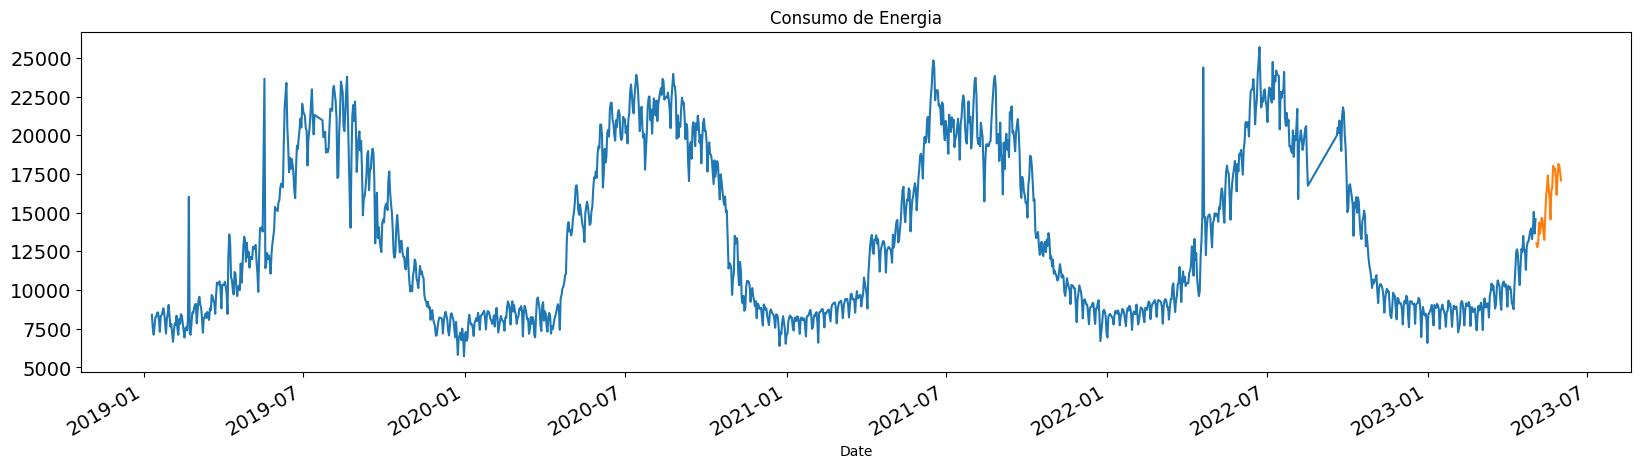

In [119]:
train[' Pronostico (MWh)'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
test[' Pronostico (MWh)'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
test.head(3)

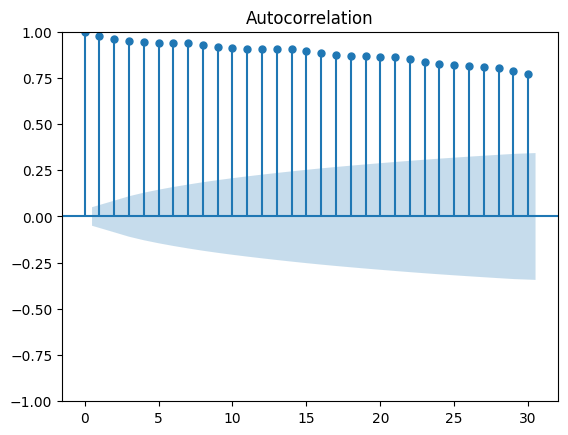

In [120]:
plot_acf(train[' Pronostico (MWh)'], lags=30)
plt.show()

La gráfica anterior traza la función de autocorrelación (ACF) de una serie temporal. La función de autocorrelación se utiliza para analizar la autocorrelación de una serie temporal con respecto a sus valores pasados.


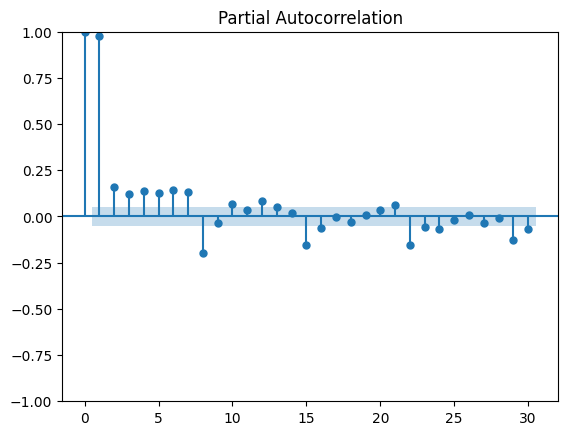

In [121]:
plot_pacf(train[' Pronostico (MWh)'], lags=30)
plt.show()

Esta gráfica traza la función de autocorrelación parcial (PACF) de una serie temporal. La PACF nos permite analizar la relación directa entre una observación y sus valores rezagados, pero teniendo en cuenta cómo los valores intermedios pueden influir en esa relación.


# Dickey Fuller's Test


El test de Dickey-Fuller (Dickey-Fuller Test) es una prueba estadística utilizada para determinar si una serie temporal tiene una raíz unitaria, es decir, si muestra un patrón de comportamiento aleatorio o si tiene una tendencia determinística.

* p is greater than 0.05 therefore the data is not stationary. After differencing, p < 0.05.


In [122]:
t = sm.tsa.adfuller(train[' Pronostico (MWh)'], autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                   -2.690565
p-value                           0.075685
#Lags Used                       23.000000
Number of Observations Used    1500.000000
dtype: float64

In [123]:
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [124]:
t = sm.tsa.adfuller(difference(train[' Pronostico (MWh)'], 1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -6.740716e+00
p-value                        3.123987e-09
#Lags Used                     2.200000e+01
Number of Observations Used    1.500000e+03
dtype: float64

# Seasonal Decomposition

<AxesSubplot: title={'center': 'Seasonality'}, xlabel='Date'>

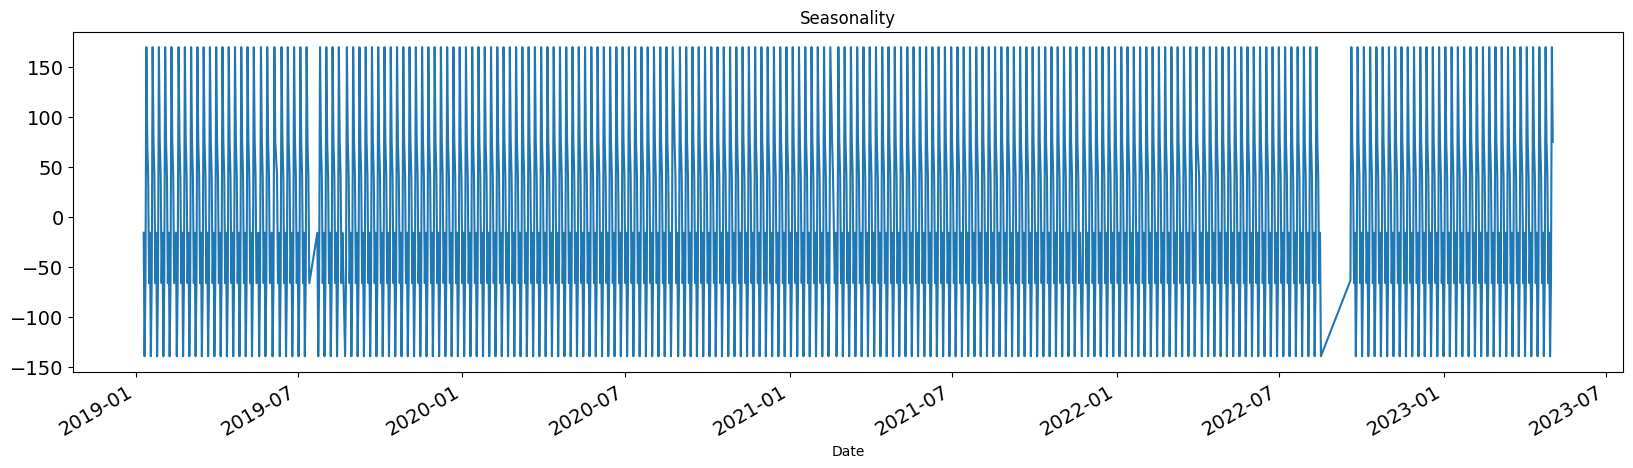

In [125]:
s = sm.tsa.seasonal_decompose(train[' Pronostico (MWh)'], period=7)
s.seasonal.plot(figsize=(20,5), title= 'Seasonality', fontsize=14)

<AxesSubplot: title={'center': 'Trend'}, xlabel='Date'>

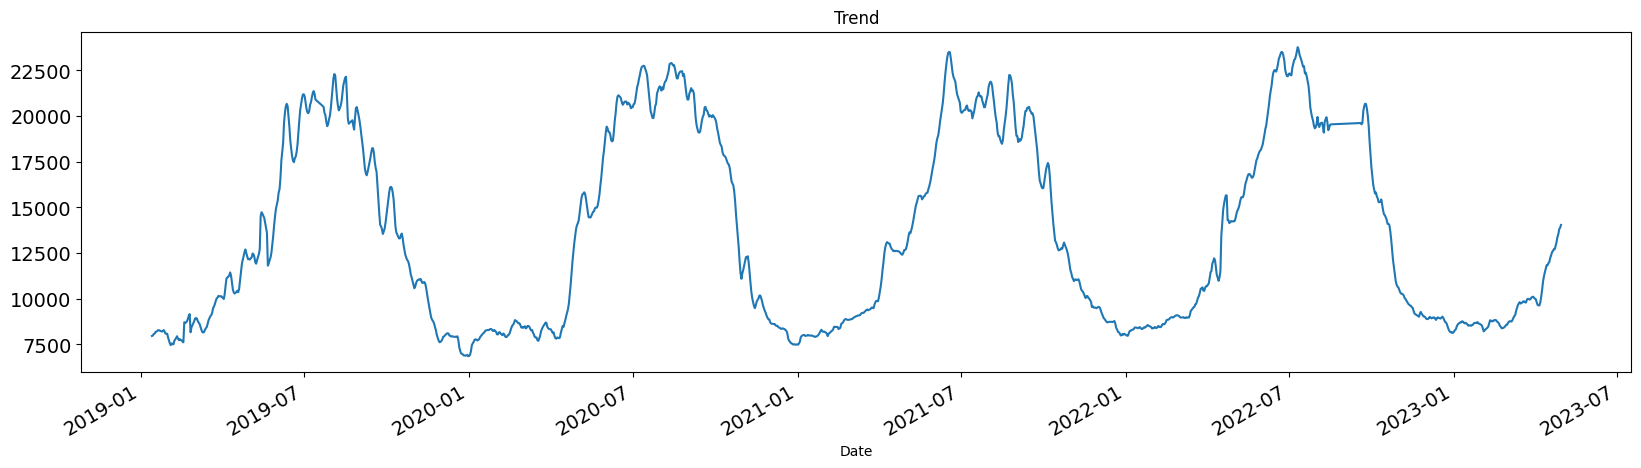

In [126]:
s.trend.plot(figsize=(20,5), title= 'Trend', fontsize=14)


<AxesSubplot: title={'center': 'Residual'}, xlabel='Date'>

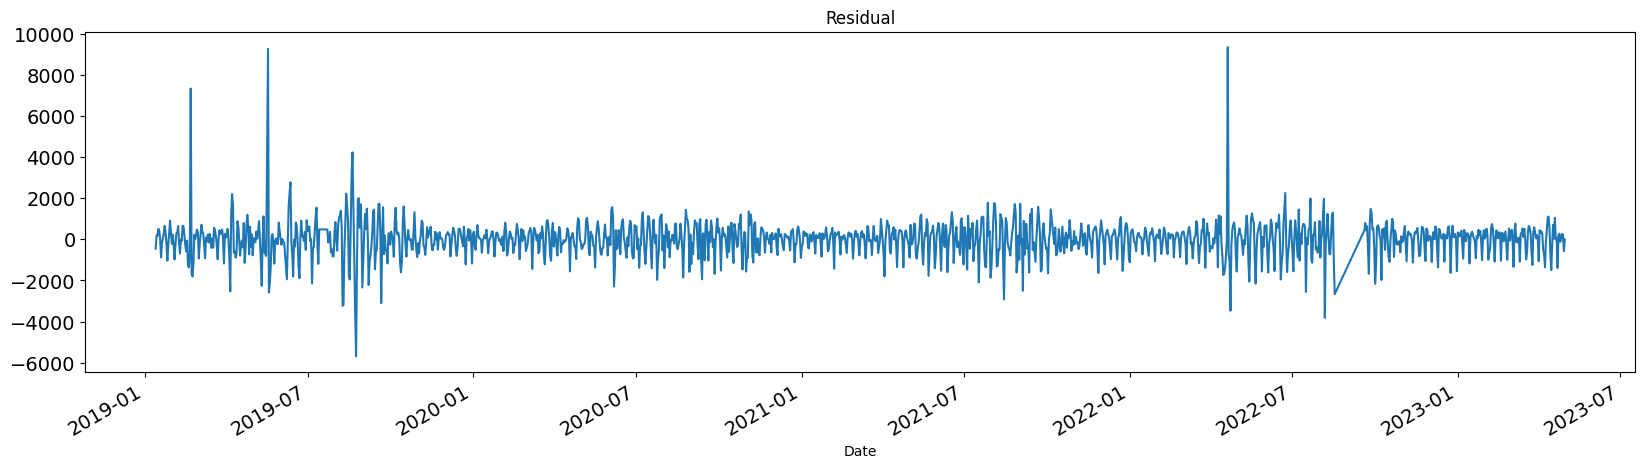

In [127]:
s.resid.plot(figsize=(20,5), title= 'Residual', fontsize=14)

In [128]:
endog = train[' Pronostico (MWh)']
exog = train[['Holiday_ind', 'clima_cluster']]
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
model_fit = mod.fit()
print(model_fit.summary())

c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                  Pronostico (MWh)   No. Observations:                 1524
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -12568.888
Date:                           Thu, 08 Jun 2023   AIC                          25151.777
Time:                                   11:28:06   BIC                          25189.002
Sample:                                        0   HQIC                         25165.641
                                          - 1524                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Holiday_ind     -37.2944    141.421     -0.264      0.792    -314.474     239.886
clima_cluster     3.4888     32.46

# Model Fit
Vemos cómo queda el modelo conforme a nuestro datos, esto mediante una gráfica y comparando

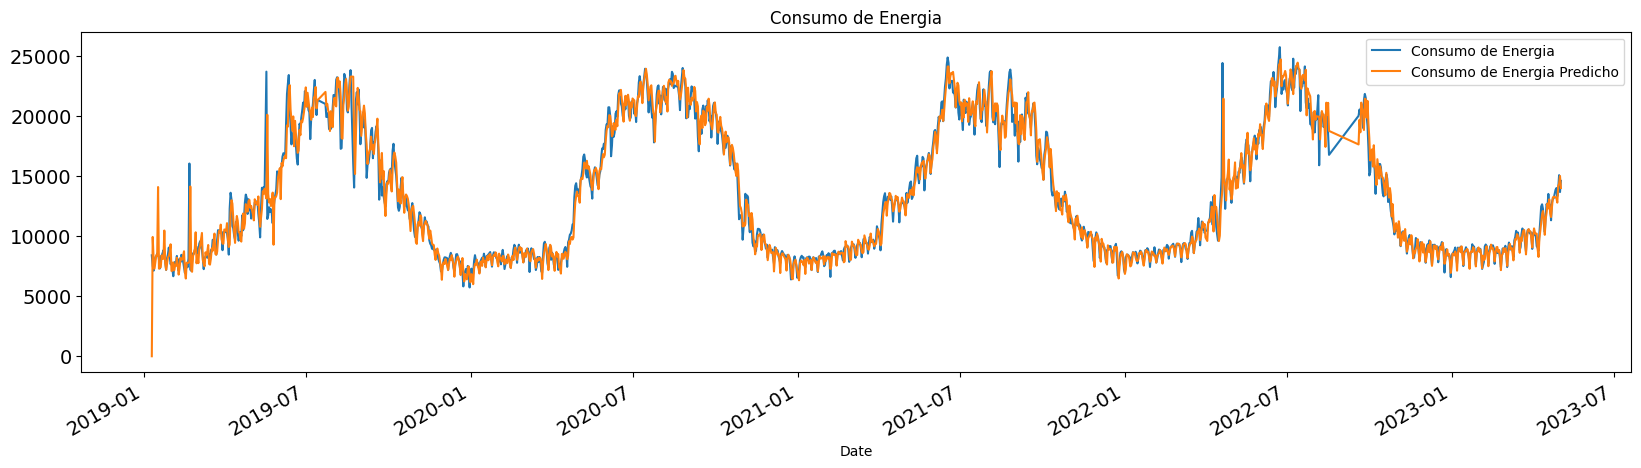

In [129]:
train[' Pronostico (MWh)'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
model_fit.fittedvalues.plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
plt.legend(['Consumo de Energia', 'Consumo de Energia Predicho'])
plt.show()

# Predicción

Predicción a futuro utilizando el modelo ajustado (model_fit)

In [130]:
predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=test[['Holiday_ind', 'clima_cluster']])
test['predicted'] = predict.values
test.tail(3)

c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Panda\AppData\Local\Temp\ipykernel_8072\4013141081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = predict.values


,Holiday_ind,Pronostico (MWh),clima_cluster,predicted
Date,,,,
2023-05-30,0,18065.694,4,16403.557805
2023-05-31,0,17591.781,4,16670.748638
2023-06-01,1,17086.090,4,16488.021286


In [131]:
test['residual'] = abs(test[' Pronostico (MWh)'] - test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (test['residual']/test[' Pronostico (MWh)']).sum()*100/len(test)
print('MAE: ', MAE)
print('MAPE: ', MAPE)

MAE:  1024.7196028646401
MAPE:  6.331701665695266


C:\Users\Panda\AppData\Local\Temp\ipykernel_8072\2578446003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = abs(test[' Pronostico (MWh)'] - test['predicted'])


* MAE (Mean Absolute Error):
El MAE es una medida de error absoluto promedio. Calcula la diferencia absoluta promedio entre las predicciones del modelo y los valores reales.

* MAPE (Mean Absolute Percentage Error):
El MAPE es una medida de error porcentual promedio. Calcula el porcentaje promedio de diferencia absoluta entre las predicciones del modelo y los valores reales en relación con los valores reales.

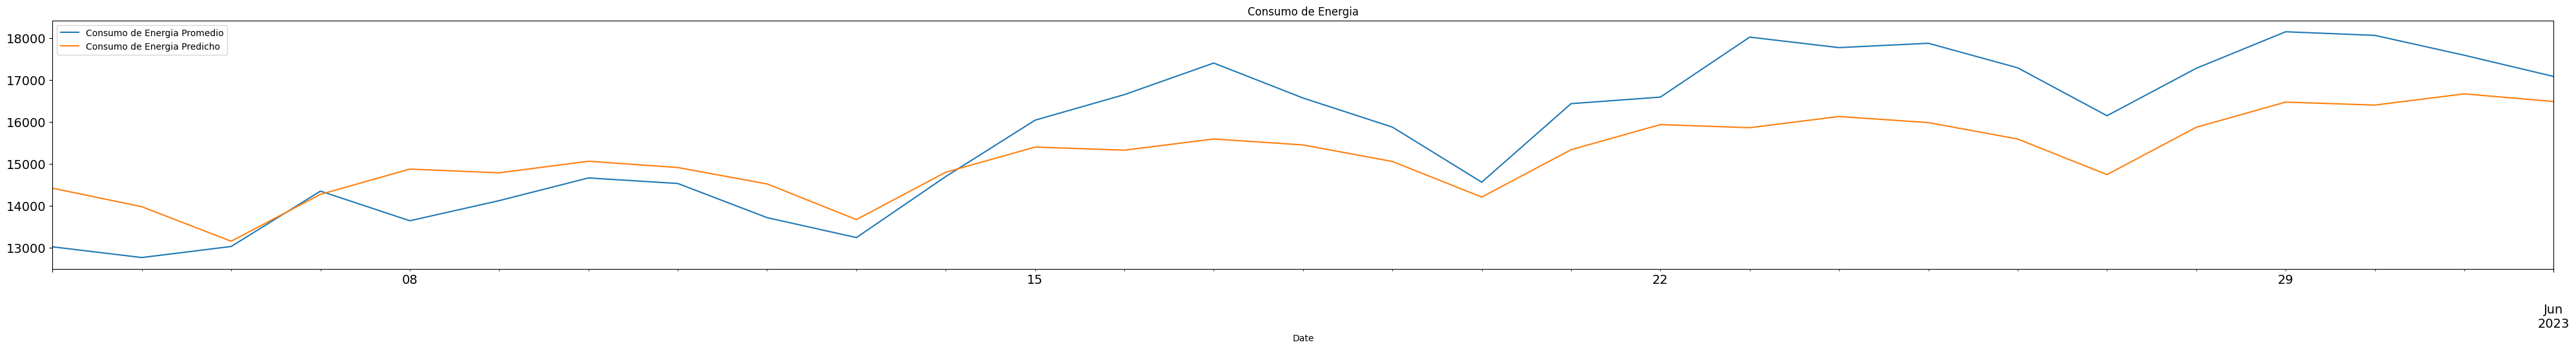

In [132]:
test[' Pronostico (MWh)'].plot(figsize=(50,5), title= 'Consumo de Energia', fontsize=14)
test['predicted'].plot(figsize=(50,5), title= 'Consumo de Energia', fontsize=14)
plt.legend(['Consumo de Energia Promedio', 'Consumo de Energia Predicho'])
plt.show()

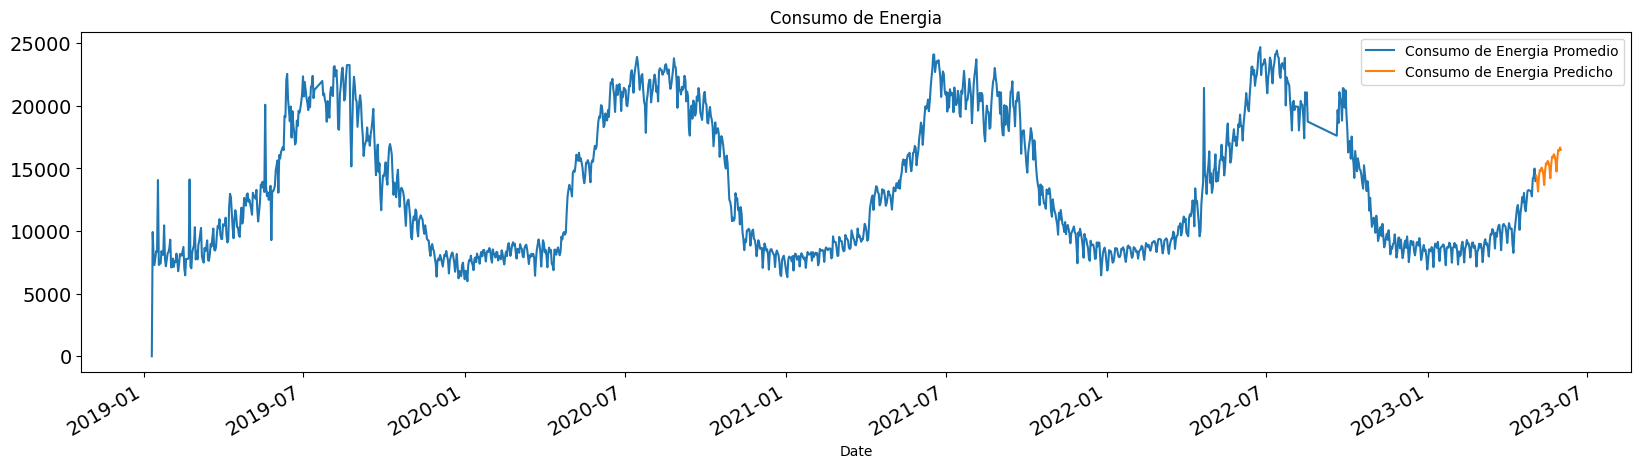

In [133]:
model_fit.fittedvalues.plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
test['predicted'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
plt.legend(['Consumo de Energia Promedio', 'Consumo de Energia Predicho'])

# LSTM
Entrenamiento de la red neuronal

In [138]:
np.random.seed(7)
df = clima_energia_2.loc[:, [' Pronostico (MWh)']]
dataset = df.values
dataset = dataset.astype('float32')

In [139]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [140]:
reframed = series_to_supervised(dataset, 7, 1)
reframed

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,8393.638672,7505.128906,7114.878906,7676.189941,8247.115234,8285.722656,8536.896484,8552.689453
8,7505.128906,7114.878906,7676.189941,8247.115234,8285.722656,8536.896484,8552.689453,8059.646973
9,7114.878906,7676.189941,8247.115234,8285.722656,8536.896484,8552.689453,8059.646973,7299.553223
10,7676.189941,8247.115234,8285.722656,8536.896484,8552.689453,8059.646973,7299.553223,8309.785156
11,8247.115234,8285.722656,8536.896484,8552.689453,8059.646973,7299.553223,8309.785156,8370.322266
...,...,...,...,...,...,...,...,...
1549,16593.423828,18024.482422,17773.912109,17877.728516,17292.224609,16149.314453,17281.500000,18152.371094
1550,18024.482422,17773.912109,17877.728516,17292.224609,16149.314453,17281.500000,18152.371094,18065.693359
1551,17773.912109,17877.728516,17292.224609,16149.314453,17281.500000,18152.371094,18065.693359,17591.781250
1552,17877.728516,17292.224609,16149.314453,17281.500000,18152.371094,18065.693359,17591.781250,17086.089844


In [141]:
reframed['clima_cluster'] = clima_energia_2['clima_cluster'].values[7:]
reframed['Holiday_ind'] = clima_energia_2['Holiday_ind'].values[7:]


In [142]:
reframed = reframed.reindex(columns=['clima_cluster', 'Holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)',  'var1(t)'])
reframed = reframed.values

# Normalization

In [143]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Imputar valores faltantes utilizando la media
imputer = SimpleImputer(strategy='mean')
reframed_imputed = imputer.fit_transform(reframed)

# Escalar características en el rango de 0 a 1
scaler = MinMaxScaler(feature_range=(0, 1))
reframed_scaled = scaler.fit_transform(reframed_imputed)

# Dividir en conjuntos de entrenamiento y prueba
train = reframed_scaled
val = reframed_scaled


In [144]:
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]

In [145]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(1547, 1, 9) (1547,) (1547, 1, 9) (1547,)


# Modelling

Epoch 1/50
22/22 - 4s - loss: 0.2216 - val_loss: 0.1189 - 4s/epoch - 182ms/step
Epoch 2/50
22/22 - 0s - loss: 0.0910 - val_loss: 0.0797 - 158ms/epoch - 7ms/step
Epoch 3/50
22/22 - 0s - loss: 0.0696 - val_loss: 0.0607 - 150ms/epoch - 7ms/step
Epoch 4/50
22/22 - 0s - loss: 0.0565 - val_loss: 0.0519 - 151ms/epoch - 7ms/step
Epoch 5/50
22/22 - 0s - loss: 0.0499 - val_loss: 0.0482 - 151ms/epoch - 7ms/step
Epoch 6/50
22/22 - 0s - loss: 0.0475 - val_loss: 0.0465 - 155ms/epoch - 7ms/step
Epoch 7/50
22/22 - 0s - loss: 0.0462 - val_loss: 0.0455 - 144ms/epoch - 7ms/step
Epoch 8/50
22/22 - 0s - loss: 0.0455 - val_loss: 0.0449 - 156ms/epoch - 7ms/step
Epoch 9/50
22/22 - 0s - loss: 0.0451 - val_loss: 0.0444 - 185ms/epoch - 8ms/step
Epoch 10/50
22/22 - 0s - loss: 0.0446 - val_loss: 0.0440 - 167ms/epoch - 8ms/step
Epoch 11/50
22/22 - 0s - loss: 0.0442 - val_loss: 0.0436 - 153ms/epoch - 7ms/step
Epoch 12/50
22/22 - 0s - loss: 0.0440 - val_loss: 0.0433 - 156ms/epoch - 7ms/step
Epoch 13/50
22/22 - 0s - l

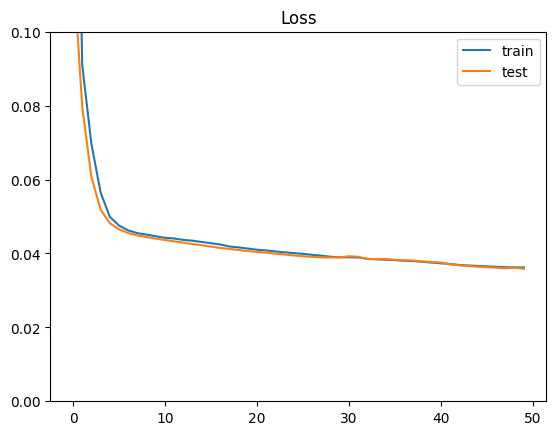

In [146]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
axis = plt.gca()
axis.set_ylim([0, 0.1])
plt.legend()
plt.show()


# Predicción con los datos de validación


En esta sección intentamos probar nuestra red con los datos de validación, sin embargo hay muchos concepto que desconocemos todavía, muchos de programación.\
Pasos que sabemos debemos seguir, pero que sin embargo no funcionaron:
 1. Datos que no haya visto el modelo antes, o sea, datos después del último día con el que fue entrenado.
 2. Darle a estos datos el mismo tratamiento por el que pasaron los de entrenamiento como los clusters, merge de dataframes, la normalización, etc.
 3. Aplicar .transform() ya que así se utiliza a la hora de aplicar la misma transformación a los datos de prueba sin necesidad de hacer ajustes (referencia al .fit_transform), o sea, es para mantener consistencia en los datos de validación.
 ```python 
    reframed_val_imputed = imputer.transform(reframed_val)
    reframed_val_scaled = scaler.transform(reframed_val_imputed)
```
 4. Finalmente hacemos los arreglos necesarios (reshapes) y evaluamos con el modelo.
    - Aquí desnormalizamos los valores y los regresamos a valores que se "entiendan".
    - Evaluamos con el modelo
    - Graficamos y observamos el performance si fue el deseado o no

In [358]:
# combinamos los archivos de validación de una fecha a otra en un solo archivo
carpet_path = r".\datos_validacion"
nombre_archivo = 'datos_validacion.csv'
combine_csv_files(carpet_path,nombre_archivo)

# lo leeemos
data = pd.read_csv('datos_validacion.csv')
data = data.loc[data[' Zona de Carga'] == 'HERMOSILLO']
data = data.groupby(['Date', ' Zona de Carga'], as_index=False)[' Pronostico (MWh)'].sum()
data['Date'] = pd.to_datetime(data['Date'])

data = data.reset_index(drop=True)
data.tail(5)


,Date,Zona de Carga,Pronostico (MWh)
6,2023-06-01,HERMOSILLO,17086.090
7,2023-06-02,HERMOSILLO,16674.799
8,2023-06-03,HERMOSILLO,16227.697
9,2023-06-04,HERMOSILLO,18516.914
10,2023-06-05,HERMOSILLO,18365.094


In [359]:

# leemos el archivo de clima
os.chdir(r"C:\Users\Panda\Documents\GitHub\energyPrediction")
clima_valid = pd.read_csv('clima_valid.csv', skiprows=18)


# Convertir las columnas 'YEAR', 'MO' y 'DY' en una columna de fecha con el formato '%Y-%m-%d'
clima_valid['Date'] = pd.to_datetime(clima_valid[['YEAR', 'MO', 'DY']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')

#Eliminar las primeras 3 columnas
clima_valid = clima_valid.drop(columns=['YEAR', 'MO', 'DY', 'ALLSKY_SFC_UV_INDEX',
     'T2M', 'T2MDEW', 'T2MWET', 'T2M_MIN', 'PRECTOTCORR',
       'PS'])

clima_energia_valid = data.merge(clima_valid, on='Date', how='inner')
clima_energia_valid = clima_energia_valid.reset_index(drop=True)
clima_energia_valid

,Date,Zona de Carga,Pronostico (MWh),WS2M,T2M_MAX,QV2M
0,2023-05-27,HERMOSILLO,16149.314,2.84,36.42,5.31
1,2023-05-28,HERMOSILLO,17281.500,2.73,35.74,5.37
2,2023-05-29,HERMOSILLO,18152.372,2.84,36.21,8.24
3,2023-05-30,HERMOSILLO,18065.694,3.29,34.65,8.00
4,2023-05-31,HERMOSILLO,17591.781,3.12,32.50,6.53
5,2023-06-01,HERMOSILLO,17086.090,2.94,31.58,6.96
6,2023-06-02,HERMOSILLO,16674.799,2.06,34.15,7.26
7,2023-06-03,HERMOSILLO,16227.697,2.37,35.81,6.04
8,2023-06-04,HERMOSILLO,18516.914,2.41,38.44,5.92
9,2023-06-05,HERMOSILLO,18365.094,2.70,37.00,6.04


In [360]:
clima_escalado_valid = scaler.fit_transform(clima_energia_valid[['T2M_MAX', 'QV2M','WS2M']])

kmeans = KMeans(n_clusters=5, max_iter=600, algorithm = 'auto')
kmeans.fit(clima_escalado_valid)
clima_energia_valid['clima_cluster'] = kmeans.labels_

c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [361]:
clima_energia_valid = clima_energia_valid.merge(holiday, left_on='Date', right_on='Fecha', how='left')
clima_energia_valid['Holiday_ind'] = np.where(clima_energia_valid['Fecha'].isnull(), 0, 1)
clima_energia_valid

,Date,Zona de Carga,Pronostico (MWh),WS2M,T2M_MAX,QV2M,clima_cluster,Fecha,Día festivo,Holiday_ind
0,2023-05-27,HERMOSILLO,16149.314,2.84,36.42,5.31,0,NaT,NaN,0
1,2023-05-28,HERMOSILLO,17281.500,2.73,35.74,5.37,0,NaT,NaN,0
2,2023-05-29,HERMOSILLO,18152.372,2.84,36.21,8.24,2,NaT,NaN,0
3,2023-05-30,HERMOSILLO,18065.694,3.29,34.65,8.00,2,NaT,NaN,0
4,2023-05-31,HERMOSILLO,17591.781,3.12,32.50,6.53,3,NaT,NaN,0
5,2023-06-01,HERMOSILLO,17086.090,2.94,31.58,6.96,3,NaT,NaN,0
6,2023-06-02,HERMOSILLO,16674.799,2.06,34.15,7.26,1,NaT,NaN,0
7,2023-06-03,HERMOSILLO,16227.697,2.37,35.81,6.04,4,NaT,NaN,0
8,2023-06-04,HERMOSILLO,18516.914,2.41,38.44,5.92,4,NaT,NaN,0
9,2023-06-05,HERMOSILLO,18365.094,2.70,37.00,6.04,4,NaT,NaN,0


In [362]:
np.random.seed(11)
df_val = clima_energia_valid.loc[:, [' Pronostico (MWh)']]
dataset_val = df_val.values
dataset_val = dataset_val.astype('float32')
dataset_val

array([[16149.314],
       [17281.5  ],
       [18152.371],
       [18065.693],
       [17591.781],
       [17086.09 ],
       [16674.799],
       [16227.697],
       [18516.914],
       [18365.094]], dtype=float32)

In [363]:
reframed_val = series_to_supervised(dataset_val, 1, 1)
reframed_val

,var1(t-1),var1(t)
1,16149.314453,17281.500000
2,17281.500000,18152.371094
3,18152.371094,18065.693359
4,18065.693359,17591.781250
5,17591.781250,17086.089844
6,17086.089844,16674.798828
7,16674.798828,16227.697266
8,16227.697266,18516.914062
9,18516.914062,18365.093750


In [364]:
reframed_val['clima_cluster'] = clima_energia_valid['clima_cluster']
reframed_val['Holiday_ind'] = clima_energia_valid['Holiday_ind']

In [365]:
reframed_val = reframed_val.reindex(columns=['clima_cluster', 'Holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)','var1(t)'])
reframed_val = reframed_val.values
reframed_val.shape

(9, 10)

In [ ]:
reframed_val_imputed = imputer.transform(reframed_val)

reframed_val_scaled = scaler.transform(reframed_val_imputed)    

test = reframed_val_scaled

In [368]:
test_X, test_y = test[:, :-1], test[:, -1]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [ ]:
# hacer una prediccion
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

# invertir la escala para la prediccion
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

# invertir la escala para los valores reales
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

# Performance

In [ ]:
act = [i[-1] for i in inv_y] # last element is the predicted average energy
pred = [i[-1] for i in inv_yhat] # last element is the actual average energy

# calculate RMSE
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test MAE: %.3f' % MAE)

In [ ]:
predicted_lstm = pd.DataFrame({'prediccion':pred,'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(25,10),color = 'red')
predicted_lstm['prediccion'].plot(color = 'blue')
plt.legend(loc='best')
plt.show()

# Conclusión
A pesar de no poder utilizar los datos de validación, creemos que el proyecto como tal fue de gran ayuda para comprender lo que hay detrás de una red neuronal. Como tal tenemos un modelo, o una red, capaz de hacer una predicción, qué tan buena, no lo sabemos. La razón principal por la cual nos quedamos "cortos" fue debido a falta de conocimiento en programación, específicamente en redes neuronales, pero como mencionamos anteriormente, fuimos capaces de construir un modelo y tenemos noción de qué es lo que viene después de esto para validar dicho modelo.

# Referencias

* rheajgurung. (2018, December 11). Energy Consumption Forecast. Kaggle.com; Kaggle. https://www.kaggle.com/code/rheajgurung/energy-consumption-forecast

* CIMAT. (2023). Women in Data Science (WiDS) 2023 [YouTube Video]. In YouTube. https://www.youtube.com/watch?v=QcP3tU3uMYo&t=3594s

* Stackhouse, P. (2022). NASA POWER | Prediction Of Worldwide Energy Resources. Nasa.gov. https://power.larc.nasa.gov/

‌